## Mixed effects modeling

In this notebook we will walk through the theory and method for estimating mixed-effect models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# set up rpy2
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

%load_ext rpy2.ipython

/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## A simple example with simulated data 

First let's generate some data containing mixed effects so that we have a testbed to play with.  We will simulate a simple example in which each individual undergoes ten repeated reaction time measurements for each of two conditions, and we wish to treat the slope across the two conditions as a random effect.

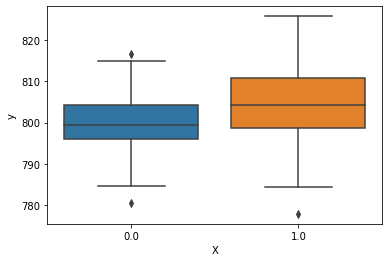

In [2]:
def generate_mixedfx_data(nsubs=20, nconds=2, nobs=10, cond_effect=5,
                          sub_sd=5, effect_sd=5, noise_sd=5, seed=1):
    """
    generate data with mixed effects
    
    parameters:
    -----------
    nsubs: number of subjects
    nconds: number of conditions per subject
    nobs: number of observations per condition/subject
    cond_effect: magnitude of condition difference
    sub_sd: SD of mean differences across subs
    effect_sd: SD of effect size differences across subs
    noise_sd: SD of random noise
    seed: random seed (set to None to use system-generated seed)
    
    returns:
    --------
    data_df: data frame containing dataset
    X_full: full fixed effects design matrix
    Z: full random effects design matrix
    b: random effect values
    """

    rng = np.random.RandomState(seed=seed)

    # fixed effect design matrix
    X = np.kron(np.ones(nsubs),
                np.hstack((np.zeros(nobs), 
                           np.ones(nobs)))).reshape(nsubs*nconds*nobs, 1)
    X = sm.add_constant(X, prepend=False)

    # full X matrix to allow random effect of X
    X_full = np.kron(np.eye(nsubs,dtype=int),
                     np.hstack((np.zeros(nobs), 
                                np.ones(nobs)))).T

    # random intercept design matrix
    Z = np.kron(np.eye(nsubs,dtype=int),
                np.ones((nobs*nconds,1)),)

    # random slope
    alpha = cond_effect + rng.randn(nsubs) * effect_sd

    # random intercept
    b = rng.randn(nsubs) * sub_sd

    # measurement noise
    e = rng.randn(X.shape[0]) * noise_sd

    intercept = 800

    y = X_full.dot(alpha).reshape(X.shape[0], 1) +\
            Z.dot(b).reshape(X.shape[0], 1) +\
            intercept +\
            e.reshape(X.shape[0], 1)


    data_df = pd.DataFrame({'y': y[:, 0],
                           'X': X[:, 0],
                           'subid': np.kron(np.arange(nsubs),
                                            np.ones(nobs * 2))},
                            index=np.arange(y.shape[0]))
    return(data_df, X_full, Z, b)

# create an example dataset
data_df, X_full, Z, b = generate_mixedfx_data()
sns.boxplot(x='X', y='y', data=data_df)

### An aside: The Kronecker product

The Kronecker product (mathematically denoted as $\otimes$) is a very useful tool for building particular kinds of matrices.  It is an extension of the *outer product* from vectors to matrices, so first let's look at the outer product.

Let's say we have two vectors of the same size:

$\textbf{u} = [u_1, u_2, \ldots, u_n]$

$\textbf{v} = [v_1, v_2, \ldots, v_n]$

Remember that the dot product of these (assuming they are 1 x n row vectors) is:

$\textbf{u} . \textbf{v} = \textbf{u} \textbf{v}^{\top} = \sum^n_1 u_i*v_i$

This produces a scalar value.  



In [56]:
u = np.array([1, 2, 3, 4])
v = np.array([1, 0, 1, 0])
u.dot(v)

4

The dot product is in fact also known as the *inner product*, so it may not surprise you that the outer product flips this around.  Given two vectors of length n, the outer product is the n x n matrix that contains $u_i * v_j$ at each location (i, j).


In [57]:
np.outer(u, v)

array([[1, 0, 1, 0],
       [2, 0, 2, 0],
       [3, 0, 3, 0],
       [4, 0, 4, 0]])

The Kronecker product extends this to matrices.  It is particularly useful for creating *block diagonal* matrices, which are often present in mixed model analyses.  For example, let's say that we want to create a matrix that has two 2x2 blocks of ones, arranged along the diagonal. We can do that using the following call to `np.kron`:

In [58]:
np.kron(np.eye(2), np.ones((2,2)))

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.]])

Let's say that we want to create a vector that contains trial labels for each of 4 subjects, where the first 5 trials are condition 1 and the second 5 are condition 2. First we create that list:

In [59]:
condlist = np.hstack((np.ones(5), np.ones(5)*2))
condlist

array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2.])

Then we use the Kronecker product to create a repeating version of it:

In [3]:
np.kron(np.ones(4),condlist )

NameError: name 'condlist' is not defined

Here are examples of the matrices $X_{full}$ and $Z$ created above using the Kronecker product:

Text(0.5, 1.0, 'Z')

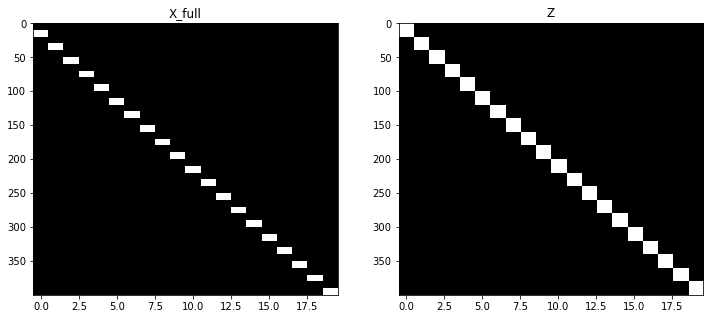

In [61]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(X_full, aspect='auto', cmap='gray')
plt.title('X_full')
plt.subplot(1,2,2)
plt.imshow(Z, aspect='auto', cmap='gray')
plt.title('Z')


### Model fitting

First let's fit an ordinary least squares model, ignoring the fact that there are repeated measurements; that is, treating each observation as independent.

In [62]:
ols = smf.ols('y ~ X', data_df)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     37.13
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           2.62e-09
Time:                        12:17:21   Log-Likelihood:                -1365.4
No. Observations:                 400   AIC:                             2735.
Df Residuals:                     398   BIC:                             2743.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    800.0732      0.521   1535.916      0.000     799.049     801.097
X              4.4887      0.737      6.093      0.000       3.040       5.937
==============================================================================
Omnibus:                        0.504   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.310
Skew:                          -0.019   Prob(JB):                        0.856
Kurtosis:                       3.131   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model assumes that observations are independent, but we know that will be false due to the fact that there are repeated observations from each individual, if those individuals differ systematically in their overall response time.  We can see this if we plot the (known) random effect of subject against the residuals from the model.

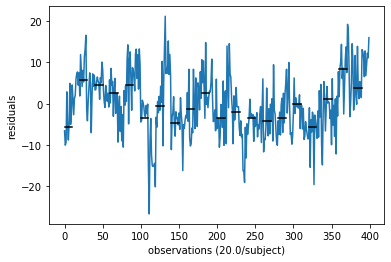

In [63]:
plt.plot(ols_result.resid)
nobs = np.sum(X_full[:,0])
nsubs = Z.shape[1]
plt.xlabel(f'observations ({nobs*2}/subject)')
plt.ylabel('residuals')
# plot a black line for the mean of each subject
for i in range(nsubs):
    plt.plot([(nobs*2*i), nobs*2*i+nobs], [b[i], b[i]], 'k')

Some individals have substantially higher residuals than others. In addition, some subjects appear to have substantially more variability in their residuals than others, meaning that the assumption of identical error distributions is also violated.  Thus, we shouldn't trust any inferences based on this model.


## The mixed-effects model

In our previous example we treated the model parameters (the effect of condition and the intercept) as *fixed effects*, meaning that there is a fixed parameter value for the effect, and any other variability is treated as random noise that is independent and identically distributed. One implication of this is that we cannot generalize beyond our sample, because another interpretation of a fixed effect is that it fully captures the population of interest.  This may make sense in the context of a particular experimental manipulation (that is, we don't generally expect our effects to generalize to new experimental conditions), but we generally *do* want to consider our sampling units (such as people in this example) as random samples from a larger population that we would like to generalize to.  When the effect of interest describes a random variable based on a sample from a population, we call that a *random effect*.  When we want to generalize to a population, then we need to assess the effect of interest with respect to the random effect variability, that is, the variability of the effect across samples from the population.

When a model includes both fixed and random effects, we refer to it as a *mixed-effects* (or *multilevel*) model.  We can write the model as follows:

$$
Y = X\beta + Zb + \epsilon
$$

where:

- $X$: known n x p design matrix - p fixed effects
- $\beta$:  vector of fixed effects
- $Z$:  known n x q design matrix - for random effects
- $b$: independent random vector, $b \sim N(0, \sigma^2\Sigma)$
    - where $\Sigma$ is the q x q relative covariance matrix for the random effects (i.e. variance of $b$ relative to $\sigma^2$)
- $\epsilon \sim N(0, \sigma^2I)$, $b \perp \epsilon$ (i.e. the random effects are independent of the errors)


## A two-stage view of mixed effects modeling

One way to think about the mixed effects model is by breaking it up into multiple stages, corresponding to the estimation of the fixed and random effects.  In essence, we first estimate the fixed effect within each group (which in our example is the different subjects), and then fit a second-level model to assess the random effect.  This is in fact how mixed-effect modeling is generally done in the context of fMRI, due to the complexities of fMRI data.

### Fitting the first level model

Let's first loop through each of our subjects and fit an OLS model to their responses, obtaining parameter estimates and their associated variances.  This model is:

$$
Y_i = X_i\beta_i + \epsilon_i
$$

where $i$ indexes the subject, and thus $\beta_i$ refers to the parameter estimates for that subject.

In [80]:
ols_params = []
ols_errors = []

for i in range(nsubs):
    df_i = data_df.query(f'subid == {i}')
    ols_result = smf.ols('y ~ X', data=df_i).fit()
    ols_params.append(ols_result.params)
    ols_errors.append(ols_result.bse)
    
ols_params = pd.DataFrame(ols_params)
ols_errors = pd.DataFrame(ols_errors)


0    -4.422189
1     7.933826
2     5.159293
3     2.640376
4     6.155598
5    -1.687123
6    -0.561257
7    -4.191708
8    -2.903249
9     4.263154
10   -4.388556
11   -1.843111
12   -3.895294
13   -4.515067
14   -2.677049
15   -0.341732
16   -6.697893
17   -0.112700
18    7.534199
19    4.550483
Name: Intercept, dtype: float64

Let's look at the distributions of the parameter values and their errors:

Text(0.5, 0, 'X SE')

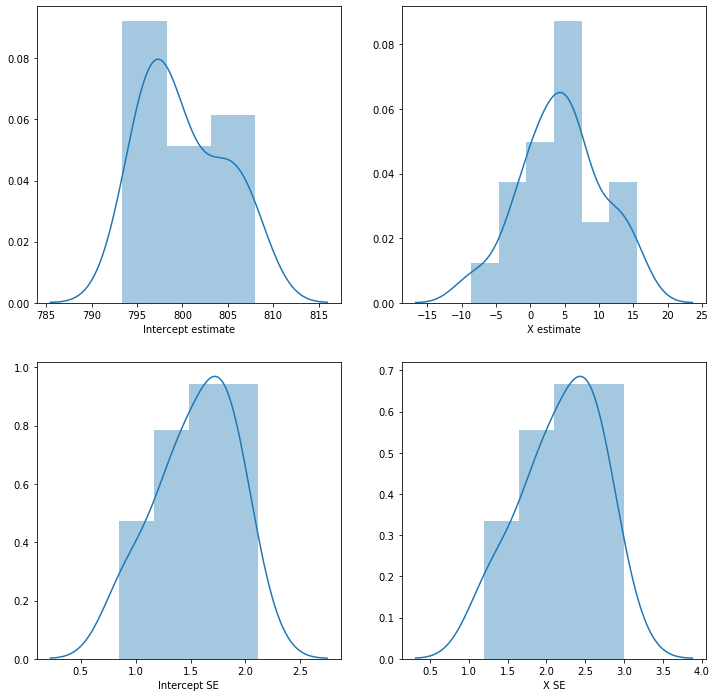

In [65]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2, ncols=2)
sns.distplot(ols_params.Intercept, ax=ax[0,0])
ax[0,0].set_xlabel('Intercept estimate')
sns.distplot(ols_params.X, ax=ax[0,1])
ax[0,1].set_xlabel('X estimate')
sns.distplot(ols_errors.Intercept, ax=ax[1,0])
ax[1,0].set_xlabel('Intercept SE')
sns.distplot(ols_errors.X, ax=ax[1,1])
ax[1,1].set_xlabel('X SE')


We see that there is a substantial amount of variability in both the parameter estimates and their variances.  

### Fitting the second level model

Now we can take the parameter estimates from the first level and fit them using a second-level model:

$$
Y_G = X_G \beta_G + \epsilon_G^*
$$

In this case, the $Y_G$ values are the parameter estimates from the first level (\[$\beta_1$ ... $\beta_n$\]).  Since we want to test whether the mean parameter estimate (i.e. the intercept) differs from zero, $X_G$ is simply a column of ones; this is equivalent to a one-sample t-test comparing the mean against zero. In this case, $\beta_G$ will simply be the mean parameter estimate across subjects.

Note that $\epsilon_G^*$ is a *mixed-effect* error term, as it includes both the variability in the $\beta_i$ estimates due to measurement noise, as well as the random-effect variability:

$$
Var(\epsilon_G^*) = \sigma^2_G I + Var_{\beta}(Y_G)
$$

The main challenge in mixed-effect modeling is to separately estimate these error terms.

Let's start by fitting an OLS model to the first-level parameter estimates, which assumes that variance is homogeneous across estimates and does not separate the common within-subject variance $\sigma^2_{win}$ and the random effect variance $\sigma^2_G$:

$$
Var(\epsilon_G^*) = (\sigma^2_{win} + \sigma^2_G)I
$$

In [66]:
level2_model = smf.ols('X ~ 1', ols_params).fit()
level2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 18 Apr 2020   Prob (F-statistic):                nan
Time:                        12:17:23   Log-Likelihood:                -63.836
No. Observations:                  20   AIC:                             129.7
Df Residuals:                      19   BIC:                             130.7
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4887      1.351      3.323      0.004       1.662       7.316
==============================================================================
Omnibus:                        0.089   Durbin-Watson:                   2.826
Prob(Omnibus):                  0.956   Jarque-Bera (JB):                0.105
Skew:                          -0.094   Prob(JB):                        0.949
Kurtosis:                       2.699   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model provides us with an inference regarding the effect of interest, but it doesn't give us a separate estimate of the random effect variance, which is what we need in order to determine whether our effect of interest can generalize to the population.  Fitting such a model requires a more sophisticated optimization algorithm (which we will return to later in the course). 



## Fitting the mixed model using `lmer()`

Probably the most popular tool for fitting mixed-effect models in psychology is the `lmer()` function from the lme4 package in R.  We will use the bridge between Python and R that is built into the Jupyter notebook in order to run `lmer()` on our data.  There are Python-based tools for mixed modeling (such as the MixedLM function in the statsmodels package), but we will use `lmer()` since it is much better known and more flexible.

To insert a cell with R code, we simply start the cell with the "magic" command `%%R`.  if we wish to import/export data to and from Python, we can do so using the `-i` and `-o` arguments.  Let's set up a mixed model for our data, including fixed effects for the intercept and condition, and a random intercept and random slope for the condition effect. This is what we would call a *maximal* model (after [Barr et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3881361/)), in the sense that it includes all possible random effects terms that are justified by the data and experimental design.

In [105]:
data_df, X_full, Z, b = generate_mixedfx_data(sub_sd=5, effect_sd=0)


In [106]:
%%R -i data_df


# load the necessary libraries
library(lme4)
library(lmerTest)

# convert numeric ID to factor
data_df$subid = as.factor(data_df$subid)

lmer_formula_maximal = 'y ~ 1 + X + (1 + X|subid)'

lmer_model_maximal = lmer(lmer_formula_maximal, data=data_df)

summary(lmer_model_maximal)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: lmer_formula_maximal
   Data: data_df

REML criterion at convergence: 2471.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.83577 -0.61070  0.01799  0.63486  2.71899 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 subid    (Intercept) 18.128   4.2577        
          X            0.195   0.4415   -1.00
 Residual             24.978   4.9978        
Number of obs: 400, groups:  subid, 20

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept) 800.0732     1.0155  19.0719  787.84   <2e-16 ***
X             5.1555     0.5094 152.4551   10.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
  (Intr)
X -0.423


In [107]:
%%R

f=model.frame(lmer_model_maximal)


In [108]:
%%R

lmer_model_maximal@devcomp

$cmp
       ldL2       ldRX2        wrss        ussq       pwrss       drsum 
  52.906973    7.951286 9500.248277  440.883185 9941.131462          NA 
       REML         dev     sigmaML   sigmaREML 
2471.091010          NA    4.985261    4.997771 

$dims
     N      n      p    nmp      q    nth  useSc reTrms   spFe   REML   GLMM 
   400    400      2    398     40      3      1      1      0      2      0 
  NLMM 
     0 



Here we see that the result is basically identical to what we found using our two-level approach.

Let's see what happens if we leave out the random slope and only include a random intercept:

In [15]:
%%R

lmer_formula_randomintercept = 'y ~ 1 + X + (1|subid)'

lmer_model_randomintercept = lmer(lmer_formula_randomintercept, data=data_df)

summary(lmer_model_randomintercept)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: lmer_formula_randomintercept
   Data: data_df

REML criterion at convergence: 2582.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3073 -0.7031  0.0762  0.6408  2.8879 

Random effects:
 Groups   Name        Variance Std.Dev.
 subid    (Intercept) 22.24    4.716   
 Residual             33.03    5.748   
Number of obs: 400, groups:  subid, 20

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept) 800.0732     1.1301  21.7126  707.94  < 2e-16 ***
X             4.4887     0.5748 379.0000    7.81 5.68e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
  (Intr)
X -0.254


Here we see that the estimated parameter value for $X$ is basically the same, but the estimated standard error is much lower, leading to an inflated statistical value.


## Maximum likelihood (ML) and restricted maximum likelihood (REML) estimation

You will notice at the top of the `lmer()` output "Linear mixed model fit by REML".  *REML* stands for "restricted maximum likelihood", which is an adaptation of the standard maximum likelihood (ML) estimation techinque. In ML estimation, we find the parameter estimates that make the observed data most likely.  This requires that we know the *likelihood function* for the data given the model, which will serve as the loss function for our estimation process; because likelihood can get very small (leading to arithmetic errors), we generally use the log-likelihood rather than the likelihood itself.

Let's take the example of simple linear regression.  In order to perform ML we need to make some assumptions to generate the likelihood function; the general assumption is that the errors are independent and identically distributed as a Gaussian distribution.  In this case, one can derive the maximum likelihood estimate for the regression parameters as:

$$
\hat{\beta} = (X'X)^{-1}X'y
$$

i.e., the same as the least squares estimates.  What about the variance of these estimates? Using the same likelihood, one can derive it as:

$$
\sigma^2_{ML} = \frac{1}{N}\sum_1^N (y - \hat{y})^2
$$

Compare this to the variance for least squares:

$$
\sigma^2_{LS} = \frac{1}{N - p}\sum_1^N (y - \hat{y})^2
$$

where $p$ is the number of parameters.  The difference is that the least squares variance uses $N - p$ as the denominator, whereas ML uses $N$.  This is essential a penalty for the fact that we first had to estimate the $p$ parameters, so we lose a degree of freedom for each.  This also means that while the ML and LS estimates will converge as the sample size goes to infinity, for smaller samples the ML variance estimate is biased downwards, which means that p-values based on these estimates are overly liberal.  This bias is larger for smaller $N$ and larger $p$.

In the context of mixed-effect modeling, one can use maximum likelihood estimation, but it fails to penalize the fixed effect variance estimates for the fact that they also involve estimating the random effects.  REML is a method that allows one to estimate the fixed effects while also taking into account the fact that random effects were estimated and penalizing the variance estimates accordingly.  This generally requires some kind of iterative optimization algorithm, like those used in `lmer()`.  `lmer()` uses REML by default, but you can turn it off (and use standard ML estimation instead) with the flag `REML=FALSE`.  If you try this on the example above you will see that it has a small effect on the variance estimate for X.




### Item analysis

In a landmark [paper](https://web.stanford.edu/~clark/1970s/Clark,%20H.H.%20_Language%20as%20fixed%20effect%20fallacy_%201973.pdf) published in 1973, Herb Clark argued that researchers need to worry about the fact that stimuli are often random samples from a population of possible stimuli, and thus should be treated as random effects.  This is an example where we have two parallel random effects: one for items, and one for subjects.

Here we will demonstrate this using simulated data based on an example from Clark's paper:

>Coleman's main point is best illustrated with
a simple example. Imagine that Baker and
Reader are two psychologists interested in
reading. Independently, they come up with
the hypothesis that people can read, that is,
perceive and vocalize, nouns faster than
verbs. To test their hypotheses, each consults
a dictionary, selects 10 nouns and I0 verbs
at random, and collects reading latencies for
the 20 words from each of 50 subjects. Let us
assume, however, that contrary to their
hypothesis nouns are in actuality exactly
equal to verbs in reading latencies. Nevertheless, since the actual latencies for individual
nouns and verbs vary from 500 to 1000 msec,
the nouns in any particular sample will not
be exactly equal to the verbs. So let us assume,
quite plausibly, that in Baker's sample the
nouns are actually 25 msec faster than the
verbs, while in Reader's there is a 25 msec
difference in the opposite direction. Independently, then, the two investigators tally
their results, Baker finding a 30 msec difference in favor of the hypothesis, and Reader, a
35 msec difference against it. And since 42
out of 50 subjects showed the difference for
Baker, and 45 out of 50 for Reader (both
differences significant at p < .001 by a sign
test), Baker reports to the public that he has
reliable support for the hypothesis, while
Reader reports that he has reliable evidence
against it. 




In [16]:
def generate_item_data(true_diff=0,
                       nitems = 20,
                       nsubs = 50,
                       sub_sd = 50,
                       item_sd = 50,
                       noise_sd=50,
                       intercept = 800,
                       seed=123):
    """
    generate simulated data for Clark (1973) example
    """
    rng = np.random.RandomState(seed=seed)
    verb = np.zeros(nitems)
    verb[:np.round(nitems/2).astype(int)] = 1
    # sample items
    item_effect = rng.randn(nitems)*item_sd + verb*true_diff
    # generate subject data
    subject_effect = rng.randn(nsubs)*sub_sd
    subject_effect = np.repeat(subject_effect[np.newaxis, :], nitems, 0).T
    
    subdata = np.repeat(item_effect[:, np.newaxis], nsubs, 1).T
    subdata = subdata + rng.randn(subdata.shape[0], subdata.shape[1])*noise_sd + subject_effect + intercept
    # make a long data frame
    subcodes =np.arange(1, nsubs+1)
    items = ['verb%02d' % i if i < np.round(nitems/2) else 'noun%02d' % i for i in range(nitems) ]
    subdata_long = subdata.reshape((nsubs*nitems, 1))
    items_long = items * nsubs
    subcodes_long = np.kron(np.array(subcodes), np.ones(nitems))
    category_long = [i[:4] for i in items_long]
    subdataDf = pd.DataFrame({'subject': subcodes_long,
                             'item': items_long,
                              'category': category_long,
                             'rt': subdata_long[:,0]})
    return(subdataDf)

itemdataDf = generate_item_data()

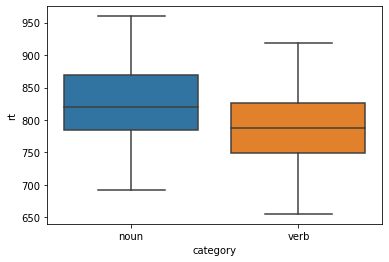

In [17]:
summaryDf = itemdataDf.groupby(['subject', 'category']).mean().reset_index() 
sns.boxplot(x='category', y='rt', data=summaryDf)

First let's run a standard analysis in which we average over items and thus don't take item-level variability into account, which will show a significant effect of word category:

In [18]:
item_fixed_model = smf.ols('rt ~ category', data=summaryDf)
result_fixed_model = item_fixed_model.fit()
result_fixed_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     9.296
Date:                Sat, 18 Apr 2020   Prob (F-statistic):            0.00295
Time:                        09:37:49   Log-Likelihood:                -546.99
No. Observations:                 100   AIC:                             1098.
Df Residuals:                      98   BIC:                             1103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          824.4028      8.208    100.443      0.000     808.115     840.691
category[T.verb]   -35.3894     11.607     -3.049      0.003     -58.424     -12.355
==============================================================================
Omnibus:                        0.191   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.909   Jarque-Bera (JB):                0.375
Skew:                           0.015   Prob(JB):                        0.829
Kurtosis:                       2.701   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model did not properly take into account the fact that items were sampled from a population, and thus should be treated as a random effect rather than a fixed effect. Let's now build a mixed effect model that properly does this, including a random effect of items as well as a random intercept and slope for subjects:

In [19]:
%%R -i itemdataDf
library(lme4)
library(lmerTest)
item_effect_model = lmer('rt ~ category + (1|item) + (1 + category|subject)', data=itemdataDf, REML=FALSE)
summary(item_effect_model)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: "rt ~ category + (1|item) + (1 + category|subject)"
   Data: itemdataDf

     AIC      BIC   logLik deviance df.resid 
 10873.9  10908.3  -5429.9  10859.9      993 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2469 -0.6069 -0.0380  0.6333  3.2090 

Random effects:
 Groups   Name         Variance Std.Dev. Corr 
 subject  (Intercept)  3484.89  59.033        
          categoryverb   49.85   7.061   -0.95
 item     (Intercept)  3541.51  59.511        
 Residual              2375.14  48.735        
Number of obs: 1000, groups:  subject, 50; item, 20

Fixed effects:
             Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)    824.40      20.70  27.89   39.82   <2e-16 ***
categoryverb   -35.39      26.81  19.98   -1.32    0.202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ca

Now we see that once we have taken the random effects of items into account, the category effect is no longer significant.

## Mixed-effects modeling: An example with real data

In this example we will analyze the reaction time data for the three-by-two task-switching task in the SRO dataset.  Here is a description of the task from the Supplementary Materials of [Enkavi et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6431228/):

>In this task (139, 140) participants respond to colored numbers (1-9) based on their color (orange or blue), magnitude (greater or less than 5), and parity. On each trial a cue informs the participant of the correct rule, which is then applied to make one of two button presses. Each rule has two cues (e.g. "orange-blue" or "color"). Cue words for each rule appear above the stimulus in each trial. On each successive trial the task and cue can stay the same, the task can stay the same and the cue can switch, or the task can switch (necessitating a cue switch). In addition, on task switch trials the task can match the task from two trials ago ("old-task", e.g. "color" -> "parity" -> "color") or differ ("new-task", e.g. "color" -> "parity" -> "magnitude"). Thus there are four trial types which were randomly sampled across trials according to the following probabilities: task-switch-old (33%), task-switch-new (33%), task-stay-cue-switch (16.5%), and task-stay-cue-stay (16.5%). The cue-target-interval (CTI) was short (100ms) for half of the trials and long (900ms) for the other half. Participants complete 60 practice trials and 440 test trials. The dependent measures for this task are the accuracy, median response time and DDM parameters for both all trials as well as for each cue-target-interval condition separately.

> 139. Logan GD, Bundesen C (2003) Clever homunculus: is there an endogenous act of control in the explicit task-cuing procedure? J Exp Psychol Hum Percept Perform 29(3):575–599.

> 140. Mayr U, Kliegl R (2003) Differential effects of cue changes and task changes on task-set selection costs. J Exp Psychol Learn Mem Cogn 29(3):362.

The main hypothesis of interest here is whether the effect of switching is greater when the CTI is long versus short.

In [2]:
from data_utils import get_SRO_data

switchdata = pd.read_csv('data/SRO/threebytwo.csv.gz', index_col=0)

# remove practice trials
switchdata = switchdata.query('exp_stage == "test"')

# remove implausible response times
switchdata = switchdata.query('rt > 200')

# remove incorrect trials
switchdata = switchdata.query('correct == True')

# convert variables to string so that they will be treated as factors
for var in ['CTI', 'stim_number']:
    switchdata[var] = [str(i) for i in switchdata[var]]

# create an overall switch vs. nonswitch variable
switchdata['switch'] = (switchdata['task_switch'] != 'stay').astype('int')


# add selected variables from main dataset into data frame
SROdata = get_SRO_data(vars=['Age'])
SROdata['worker_id'] = SROdata.index
switchdata = switchdata.join(SROdata,on='worker_id', rsuffix='_r')
del switchdata['worker_id_r']

switchdata.columns

Index(['CTI', 'battery_name', 'correct', 'correct_response', 'cue',
       'cue_switch', 'exp_stage', 'experiment_exp_id', 'finishtime',
       'focus_shifts', 'full_screen', 'key_press', 'possible_responses', 'rt',
       'stim_color', 'stim_number', 'stimulus', 'switch_type', 'task',
       'task_switch', 'time_elapsed', 'trial_id', 'trial_num', 'trial_type',
       'worker_id', 'switch', 'Age'],
      dtype='object')

In [3]:
nsubs = np.unique(switchdata.worker_id).shape[0]
print(f'found {nsubs} unique subjects')

found 521 unique subjects


Response time distributions are generally skewed, and sometimes have outliers that can impact analyses.  For this reason, it is common to drop outlier trials.  Let's look at the distribution of response times:

proportion of RTs greater than 2500 ms: 0.00004


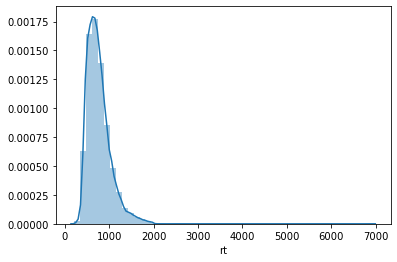

In [4]:
# plot the full distribution of response times

sns.distplot(switchdata.rt)

cutoff = 2500
p_exceed_cutoff = np.mean(switchdata.rt > cutoff)
print(f'proportion of RTs greater than {cutoff} ms: {p_exceed_cutoff:.5f}')

The 2500 ms cutoff excludes very few trials, so let's use that to clean the distribution. 


In [5]:
switchdata = switchdata.query('rt <= 2000')

## Modeling switch costs

We could imagine performing an analysis where we put all response times for all subjects into a single model.  Let's fit that model using OLS:

In [24]:
formula = 'rt ~ 1 + CTI*switch'

mod = smf.ols(formula=formula, data=switchdata)
res = mod.fit()
switchdata['resid_OLS'] = res.resid
res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Sat, 18 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:37:56   Log-Likelihood:            -1.3298e+06
No. Observations:              192804   AIC:                         2.660e+06
Df Residuals:                  192800   BIC:                         2.660e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             816.3989      1.319    618.909      0.000     813.813     818.984
CTI[T.900.0]         -179.2778      1.849    -96.977      0.000    -182.901    -175.654
switch                 77.6654      1.639     47.378      0.000      74.452      80.878
CTI[T.900.0]:switch   -44.9217      2.290    -19.616      0.000     -49.410     -40.433
==============================================================================
Omnibus:                    55800.512   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           161213.939
Skew:                           1.527   Prob(JB):                         0.00
Kurtosis:                       6.277   Cond. No.                         8.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

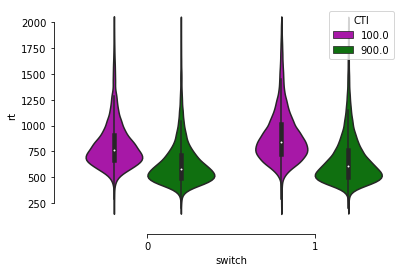

In [25]:

sns.violinplot(x="switch", y="rt",
            hue="CTI", palette=["m", "g"],
            data=switchdata)
sns.despine(offset=10, trim=True)
plt.savefig('rt_by_condition.pdf')

There are a couple of problems with this analysis.  First, it assumes that both the intercept and the effects estimated in the model are the same for all individuals; that is, they are fixed effects.  Second, it assumes that the residuals are independent and identically distributed.  

Let's look at the distribution of mean residuals across subjects.

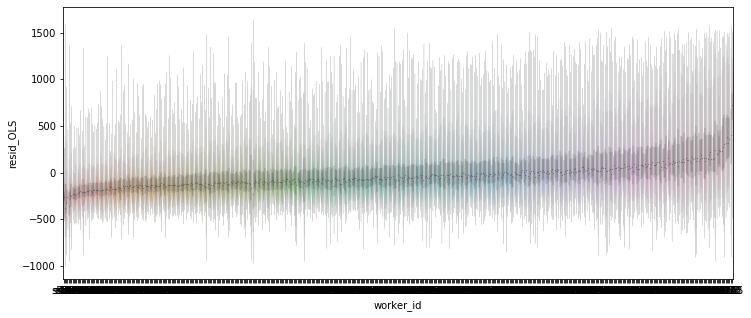

In [26]:
mean_resid_by_subject = switchdata.groupby(['worker_id']).resid_OLS.mean().sort_values()

plt.figure(figsize=(12,5))
sns.violinplot(x='worker_id', y='resid_OLS', 
               data=switchdata, 
               order=mean_resid_by_subject.index,
               linewidth=0.1,
               plot_kws=dict(alpha=0.3))
plt.savefig('OLS_residual_violin.pdf')

If we compare the mean residual for each subject to their mean response time, we will see that they are almost perfectly related:

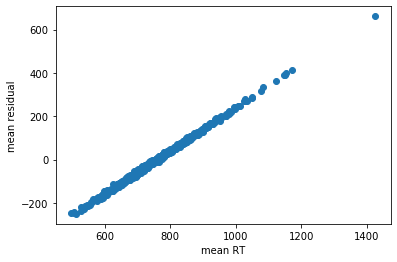

In [27]:
mean_rt_by_subject = switchdata.groupby(['worker_id']).rt.mean()
resid_df = pd.DataFrame(mean_resid_by_subject).join(mean_rt_by_subject)
plt.scatter(resid_df.rt, resid_df.resid_OLS)
plt.xlabel('mean RT')
plt.ylabel('mean residual')
plt.savefig('OLS_residual_vs_rt.pdf')



In order to see how these various effects differ across subjects, we can apply the OLS model separately to each subject, and then look at the distributions of parameter estimates; this is exactly what we did above, as the first stage of the two-stage model.

In [28]:
subject_ids = np.unique(switchdata.worker_id)
subject_vars = pd.DataFrame(index=subject_ids)
subject_vars['resid_sd'] = 0

formula = 'rt ~ 1 + CTI*switch'

switchdata['resid'] = 0
sub_betas = []
sub_bse = []
sub_n = []

for i, sub in enumerate(subject_ids):
    subdata = switchdata.query(f'worker_id == "{sub}"')
    res = smf.ols(formula=formula, data=subdata).fit()
    sub_betas.append(res.params)
    sub_bse.append(res.bse)
    sub_n.append(subdata.groupby(['CTI', 'switch']).rt.count())
    resid = subdata.rt - res.predict(subdata, transform=True)
    subject_vars.loc[sub, 'resid_sd'] = np.std(resid)
    switchdata.loc[switchdata.worker_id == sub, 'resid_sd'] = np.std(resid)
    switchdata.loc[switchdata.worker_id == sub, 'resid'] = resid

In [29]:
sub_betas_df = pd.DataFrame(sub_betas).rename({'CTI[T.900.0]': 'CTI',
                                               'CTI[T.900.0]:switch': 'CTIxSwitch'}, axis='columns')
sub_bse_df = pd.DataFrame(sub_bse).rename({'CTI[T.900.0]': 'CTI',
                                               'CTI[T.900.0]:switch': 'CTIxSwitch'}, axis='columns')
sub_n_df = pd.DataFrame(sub_n)
sub_n_df.columns = ['ns_100', 's_100', 'ns_900', 's_900']
sub_bse_df['N'] = sub_n_df.sum(1).values

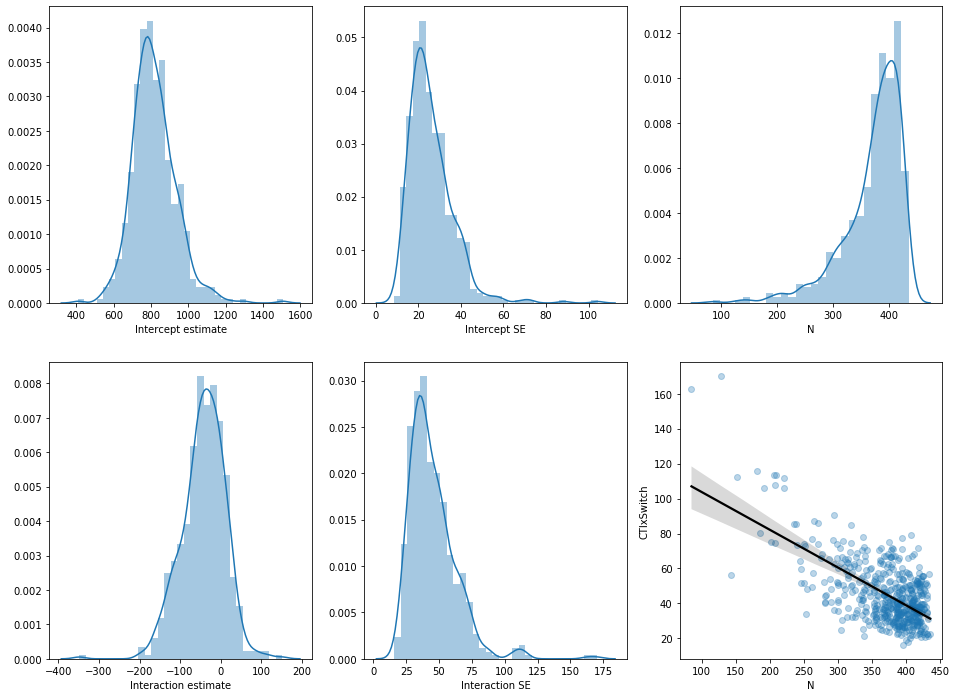

In [30]:
fix, ax = plt.subplots(figsize=(16,12), nrows=2, ncols=3)
sns.distplot(sub_betas_df.Intercept, ax=ax[0][0], axlabel='Intercept estimate')
sns.distplot(sub_bse_df.Intercept, ax=ax[0][1], axlabel='Intercept SE')
sns.distplot(sub_n_df.sum(1), ax=ax[0][2], axlabel='N')

sns.distplot(sub_betas_df.CTIxSwitch, ax=ax[1][0], axlabel='Interaction estimate')
sns.distplot(sub_bse_df.CTIxSwitch, ax=ax[1][1], axlabel='Interaction SE')
sns.regplot(x='N', y='CTIxSwitch', data=sub_bse_df, scatter_kws={'alpha':0.3}, line_kws={'color':'k'})
np.corrcoef(sub_bse_df.N, sub_bse_df.CTIxSwitch)[0,1]
plt.savefig('random_effects.pdf')

We can see that there is substantial variability in both the parameter estimates and their standard errors, and that the differences in standard error are strongly related to the number of trials per individual.

Let's focus on the interaction effect (since it is of greatest scientific interest), ignoring for the moment the heteroscedasticity that is clearly present in the data.  We can perform the second-level analysis using OLS to estimate the mean interaction effect:

In [31]:
res = smf.ols(formula='CTIxSwitch ~ 1', data=sub_betas_df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CTIxSwitch   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 18 Apr 2020   Prob (F-statistic):                nan
Time:                        09:39:18   Log-Likelihood:                -2812.0
No. Observations:                 521   AIC:                             5626.
Df Residuals:                     520   BIC:                             5630.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.2083      2.343    -18.013      0.000     -46.812     -37.605
==============================================================================
Omnibus:                       48.077   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.802
Skew:                          -0.501   Prob(JB):                     8.70e-25
Kurtosis:                       5.025   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results from this model are based on the assumption that the variances of each observation are equal, but we know from the plot above that this is not the case, and in fact they differ very substantially across participants.  

One relatively simple way to estimate the model taking this into account is to use *generalized least squares* (GLS: not to be confused with the generalized linear model).  GLS allows one to estimate the model using a non-identity covariance matrix.  Here we will focus on the case where the covariance matrix is diagonal (that is, the observations are independent) but the values along the diagonal can vary (i.e. the variances differ between observations).  

The formula for GLS estimation is:

$$
\hat{\beta} = (X'V^{-1}X)^{-1}X'V^{-1}Y
$$

where V is the covariance matrix which now has varying values along its diagonal.  One way to think of this is that the model is weighting the contribution of each observation based on its variance, such that values with more precise estimates are weighted more strongly.  Since we know the estimated variability of the parameter estimates from each participant (i.e. the standard error), we can use these to estimate our model, using the `GLS` function in statsmodels, which takes in the covariance matrix $V$ as an argument.  This is equivalent to performing *weighted least squares* using the inverse variances as the weights.

In [32]:
# create the covariance matrix for the parameter estimates
V = np.diag(sub_bse_df.CTIxSwitch**2)

# compute GLS estimate
mod_gls = smf.gls('CTIxSwitch ~ 1', sub_betas_df, sigma=V)
res_gls = mod_gls.fit()
print(res_gls.summary())

                            GLS Regression Results                            
Dep. Variable:             CTIxSwitch   R-squared:                       0.000
Model:                            GLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 18 Apr 2020   Prob (F-statistic):                nan
Time:                        09:39:18   Log-Likelihood:                -2762.9
No. Observations:                 521   AIC:                             5528.
Df Residuals:                     520   BIC:                             5532.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.4066      1.894    -20.282      0.0

The GLS model above assumed that all of the differences in variance between subjects came from estimation error at the first level, but for a complete mixed effects model we need to separately estimate the fixed effect and random effect error terms, which requires a more complex estimation procedure like that used in `lmer`.

To specify the same model that we used above in `lmer`, we would use a formula like this:

> `rt ~ 1 + CTI\*switch + (1 + CTI\*switch|worker_id)`

The first part looks like like the model that we used above for each individual subject, specifying that we want to model an intercept along with the main effects of CTI and switch and their interaction.  These are the fixed effects that we want to estimate.  The second part (contained in the parentheses) reflect the *random effects*.  In this case, this is basically saying that we want to estimate a separate intercept, main effects, and interaction effect for each participant (who are denoted by the *worker_id* variable).  Again, this is a maximal model for this design. These will then be combined to estimate each of the specified fixed effects.

Let's estimate this model:

In [11]:
# remove extraneous variables, which were causing problems for pandas2ri
switchdata_for_lmer = switchdata[['rt', 'CTI', 'worker_id', 'cue', 
                                  'switch', 'task', 'stim_number',
                                  'trial_num']]


In [12]:
%%R -i switchdata_for_lmer

# if the saved file already exists then use it instead of re-estimating
# if you want to re-estimate, then just delete the file

library(lme4)
library(lmerTest)
library(optimx)

if (file.exists('lmer_model.RData')){
    load('lmer_model.RData')
} else {
    # load the necessary libraries

    lmer_formula = 'rt ~ 1 + CTI*switch + (1 + CTI*switch|worker_id)'

    # this model has trouble converging - tried various optimizers
    # none converge but nlminb comes closest

    ctrl_nlminb = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb', maxit = 1e9))
    lmer_model = lmer(lmer_formula, data=switchdata_for_lmer,
                control = ctrl_nlminb, REML=TRUE)
    save(lmer_model, file='lmer_model.RData')
}

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [35]:
%%R -o lmer_resid

s = summary(lmer_model)
print(s)

lmer_resid = resid(lmer_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: lmer_formula
   Data: switchdata_for_lmer
Control: ctrl_nlminb

REML criterion at convergence: 2608390

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6445 -0.6165 -0.1892  0.4134  6.9637 

Random effects:
 Groups    Name            Variance Std.Dev. Corr             
 worker_id (Intercept)     12790.8  113.10                    
           CTI900.0         1713.4   41.39   -0.51            
           switch           2198.4   46.89    0.48 -0.44      
           CTI900.0:switch   536.4   23.16   -0.34  0.55 -0.71
 Residual                  43058.9  207.51                    
Number of obs: 192804, groups:  worker_id, 521

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)      817.229      5.088  517.674  160.63   <2e-16 ***
CTI900.0        -179.455      2.427  495.794  -73.95   <2e-16 ***
switch            77.293      2.505  507.221

We know that response times are generally skewed, so that the error distribution is likely to be non-Gaussian. Let's look at the distribution of residuals using a histogram and Q-Q plot:

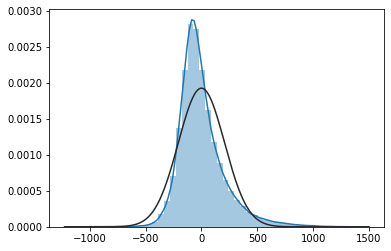

In [36]:
sns.distplot(lmer_resid, fit=scipy.stats.norm)

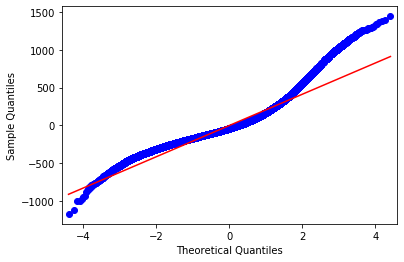

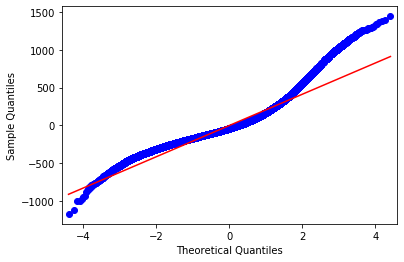

In [37]:
from statsmodels.graphics.gofplots import qqplot
qqplot(lmer_resid, line='s')

The residuals from this model seem to exhibit pretty substantial deviation from normality, causing some concern about the results (particular the inferences regarding model parameters). We can try running the same model using a Gamma error family, which is a commonly used distribution for response time models.  This is a *generalized linear model* so we need to use the `glmer()` function in lme4, and specify the Gamma error family and log link function.

In [38]:
%%R 

# if the saved file already exists then use it instead of re-estimating
# if you want to re-estimate, then just delete the file

if (file.exists('lmer_model_Gamma.RData')){
    load('lmer_model_Gamma.RData')
} else {
    lmer_formula = 'rt ~ 1 + CTI*switch + (1 + CTI*switch|worker_id)'
    ctrl_nlminb = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb', maxit = 1e9))

    glmer_model = glmer(lmer_formula, data=switchdata_for_lmer,
                family=Gamma(link = "log"),
                control = ctrl_nlminb)
    save(glmer_model, file='lmer_model_Gamma.RData')
}


In [39]:
%%R

s = summary(glmer_model)
print(s)

lmer_resid = resid(glmer_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: rt ~ 1 + CTI * switch + (1 + CTI * switch | worker_id)
   Data: switchdata_for_lmer
Control: ctrl_nlminb

     AIC      BIC   logLik deviance df.resid 
 2558908  2559061 -1279439  2558878   192789 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0363 -0.6459 -0.2006  0.4265 10.8146 

Random effects:
 Groups    Name            Variance Std.Dev. Corr             
 worker_id (Intercept)     0.004178 0.06464                   
           CTI900.0        0.002718 0.05213  -0.27            
           switch          0.001773 0.04211  -0.16  0.07      
           CTI900.0:switch 0.002221 0.04713   0.13 -0.43 -0.44
 Residual                  0.073851 0.27176                   
Number of obs: 192804, groups:  worker_id, 521

Fixed effects:
                 Estimate Std. Error t value Pr(>|z|)    
(Intercept)      6.694320   0.007508  891.66   <2e-16 ***

This model actually converged, with slightly better fit than the previous model (based on comparison of AIC/BIC):

In [40]:
%%R

lmer_model_ml = refitML(lmer_model)
AIC(logLik(lmer_model_ml))

[1] 2608435


Notably, the t statistic for the interaction effect is much smaller than it was for the previous model, though still highly significant.

It turns out that there was another factor in our data that likely results in differences in reaction time, but which we didn't include in our model: the task (parity, color, or magnitude).

In [8]:
switchdata.groupby(['task']).rt.describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
color,65977.0,725.772072,258.730321,201.0,532.0,680.0,857.0,1997.0
magnitude,64755.0,751.238839,256.926029,201.0,564.0,700.0,875.0,2000.0
parity,62072.0,803.856312,266.134996,201.0,616.0,751.0,927.0,2000.0


The three tasks differ fairly substantially in their mean response times, suggesting that they should be included in the model. Let's try fitting a maximal model that includes a random effect for task in addition to the other effects above (again using the Gamma error family).

In [ ]:
%%R -i switchdata_for_lmer

if (file.exists('lmer_model_maximal.RData')){
    load('lmer_model_maximal.RData')
} else {
    lmer_formula_maximal = 'rt ~ 1 + CTI*switch + (1 + CTI*switch|worker_id) + (1|task)'
    ctrl_nlminb = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb', maxit = 1e9))

    lmer_model_maximal = glmer(lmer_formula_maximal, data=switchdata_for_lmer,
                family=Gamma(link = "log"),
                control = ctrl_nlminb)
    save(lmer_model_maximal, file='lmer_model_maximal.RData')
}



In [ ]:
%%R

s = summary(lmer_model_maximal)
print(s)



In [15]:
%%R

lmer_model_maximal_ml = refitML(lmer_model_maximal)
AIC(logLik(lmer_model_maximal_ml))

[1] 2603661


threebytwo_s000_0307       parity
threebytwo_s000_0311       parity
threebytwo_s000_0327    magnitude
threebytwo_s000_0335       parity
threebytwo_s000_0339    magnitude
                          ...    
threebytwo_s521_2047        color
threebytwo_s521_2051        color
threebytwo_s521_2055    magnitude
threebytwo_s521_2059        color
threebytwo_s521_2063    magnitude
Name: task, Length: 192804, dtype: object